In [53]:
from sklearn.datasets import make_moons, make_classification
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader 

import matplotlib.pyplot as plt
plt.style.use('./pptnqfe.mplstyle')

from qulearn.qkernel import QKernel
from qulearn.qlayer import ParallelIQPEncoding, Linear2DBasisQFE
from qulearn.hat_basis import HatBasis
from qulearn.trainer import RidgeRegression

In [54]:
# Wrapper to convert real-valued output to binary output
class SignModelWrapper(torch.nn.Module):
    def __init__(self, old_model):
        super(SignModelWrapper, self).__init__()
        self.old_model = old_model

    def forward(self, x):
        real_value_output = self.old_model(x)
        binary_output = torch.sign(real_value_output)
        return binary_output

# Section 5.3

In [55]:
# Bounds away from 1.0 because QuLearn out of bounds not implemented yet
xmin = -0.99
xmax = -1*xmin
dx = xmax - xmin

In [56]:
# Set for reproducibility
random_state = 42

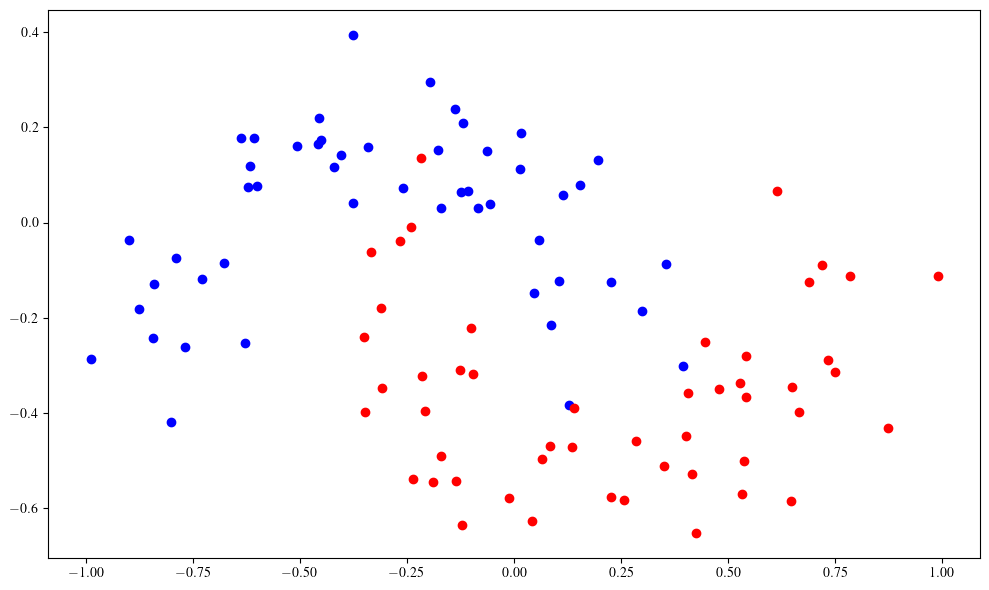

In [57]:
n_samples = 100
X, y = make_moons(n_samples=100, noise=0.2, random_state=random_state)

X_min = X.min()
X_max = X.max()
X = dx * (X - X_min) / (X_max - X_min) + xmin

# Plot the dataset
plt.figure(figsize=(10, 6))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='blue', label='Class 0')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='red', label='Class 1')
plt.tight_layout()
plt.savefig('./figures/moons.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [58]:
# QFE parameters
base = 3.0
omega = 1.0
num_qubits = 3
num_nodes = 2**num_qubits

# Hat basis
a = -1.0
b = 1.0
hat_basis = HatBasis(a=a, b=b, num_nodes=num_nodes)

# QFE
embed_pptn = Linear2DBasisQFE(wires=2*num_qubits,
                              basis=hat_basis,
                              sqrt=True,
                              normalize=False,
                              zorder=True)

embed_pqc = ParallelIQPEncoding(wires=2*num_qubits,
                                num_features=2,
                                n_repeat=1,
                                base=base,
                                omega=omega)

In [59]:
# Split into training and validation sets
def split_data(X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                      test_size=0.2,
                                                      random_state=random_state)
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float64)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float64)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float64)
    
    # Convert y values from {0, 1} to {-1, 1}
    y_train_tensor = 2 * y_train_tensor - 1
    y_val_tensor = 2 * y_val_tensor - 1
    
    # Create TensorDatasets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    
    # Create DataLoaders
    train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset),     shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
    
    return train_dataloader, val_dataloader, X_train_tensor

In [60]:
train_dataloader, val_dataloader, X_train_tensor = split_data(X, y)

kernel_model_pqc = QKernel(embed_pqc, X_train_tensor)
trainer = RidgeRegression(lambda_reg=1.0)
trainer.train(kernel_model_pqc, train_dataloader, val_dataloader)

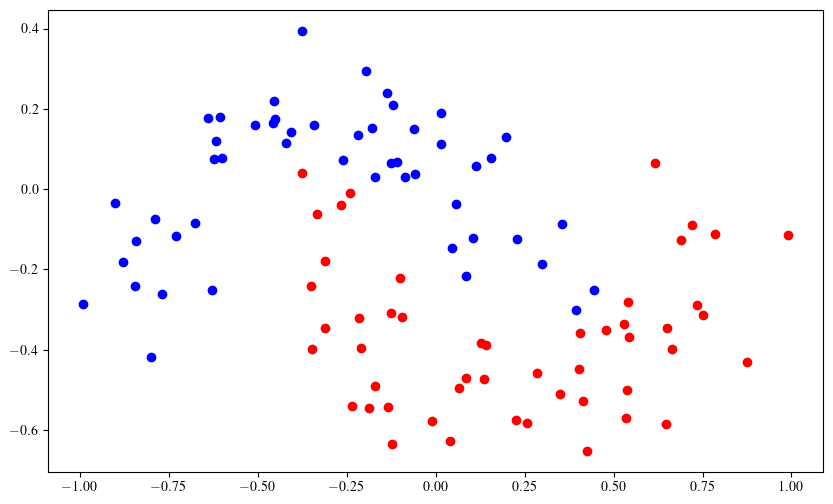

In [61]:
kernel_pqc_classifier = SignModelWrapper(kernel_model_pqc)

X_tensor = torch.tensor(X, dtype=torch.float64)
y = kernel_pqc_classifier(X_tensor)

# Plot the dataset
plt.figure(figsize=(10, 6))
plt.scatter(X[y == -1][:, 0], X[y == -1][:, 1], color='blue', label='Class 0')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='red', label='Class 1')
plt.savefig('./figures/moons_pqc.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [62]:
kernel_model_pptn= QKernel(embed_pptn, X_train_tensor)
trainer.train(kernel_model_pptn, train_dataloader, val_dataloader)

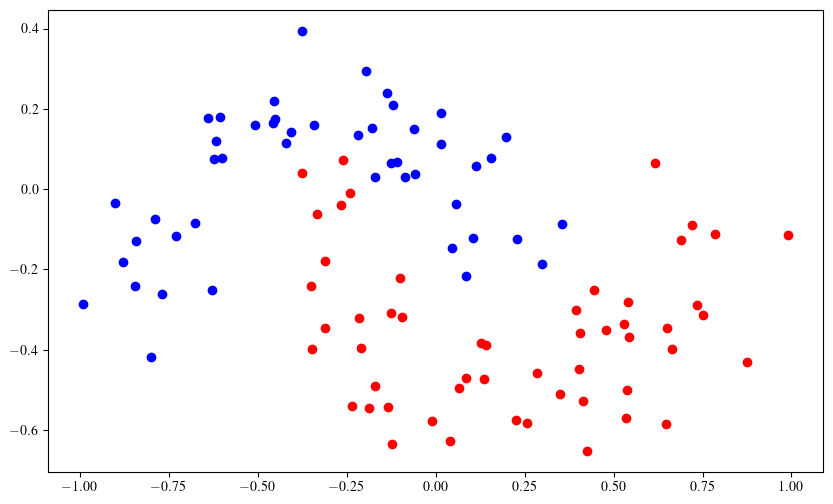

In [63]:
kernel_pptn_classifier = SignModelWrapper(kernel_model_pptn)

y = kernel_pptn_classifier(X_tensor)

# Plot the dataset
plt.figure(figsize=(10, 6))
plt.scatter(X[y == -1][:, 0], X[y == -1][:, 1], color='blue', label='Class 0')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='red', label='Class 1')
plt.savefig('./figures/moons_pptn.pdf', format='pdf', bbox_inches='tight')
plt.show()

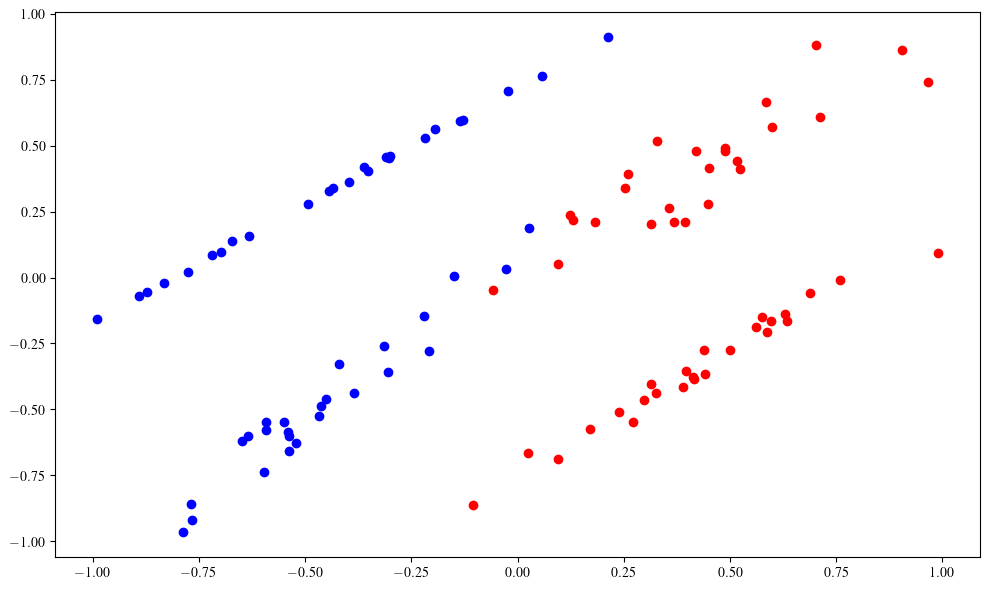

In [64]:
n_samples = 100
X, y = make_classification(n_samples=100,
                           n_features=2,
                           n_informative=2,
                           n_redundant=0,
                           random_state=random_state)

X_min = X.min()
X_max = X.max()
X = dx * (X - X_min) / (X_max - X_min) + xmin

# Plot the dataset
plt.figure(figsize=(10, 6))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='blue', label='Class 0')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='red', label='Class 1')
plt.tight_layout()
plt.savefig('./figures/lines.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [65]:
train_dataloader, val_dataloader, X_train_tensor = split_data(X, y)
kernel_model_pqc = QKernel(embed_pqc, X_train_tensor)
trainer.train(kernel_model_pqc, train_dataloader, val_dataloader)

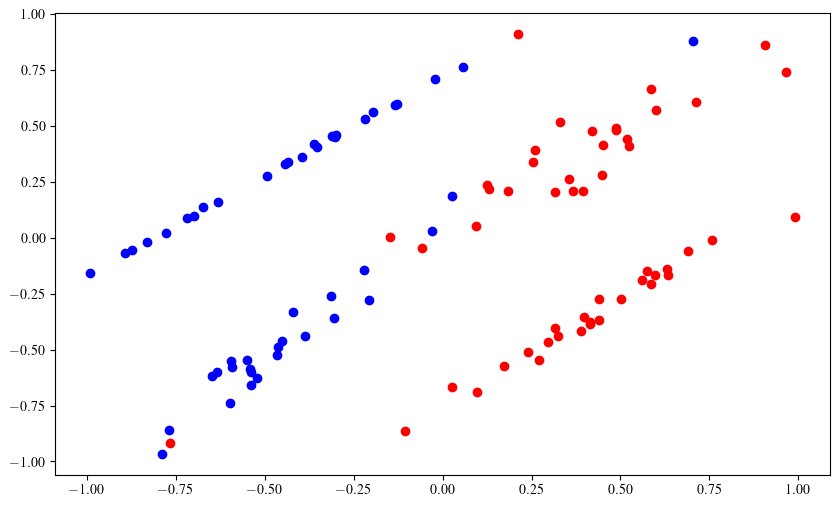

In [66]:
kernel_pqc_classifier = SignModelWrapper(kernel_model_pqc)

X_tensor = torch.tensor(X, dtype=torch.float64)
y = kernel_pqc_classifier(X_tensor)

# Plot the dataset
plt.figure(figsize=(10, 6))
plt.scatter(X[y == -1][:, 0], X[y == -1][:, 1], color='blue', label='Class 0')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='red', label='Class 1')
plt.savefig('./figures/lines_pqc.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [67]:
kernel_model_pptn = QKernel(embed_pptn, X_train_tensor)
trainer.train(kernel_model_pptn, train_dataloader, val_dataloader)

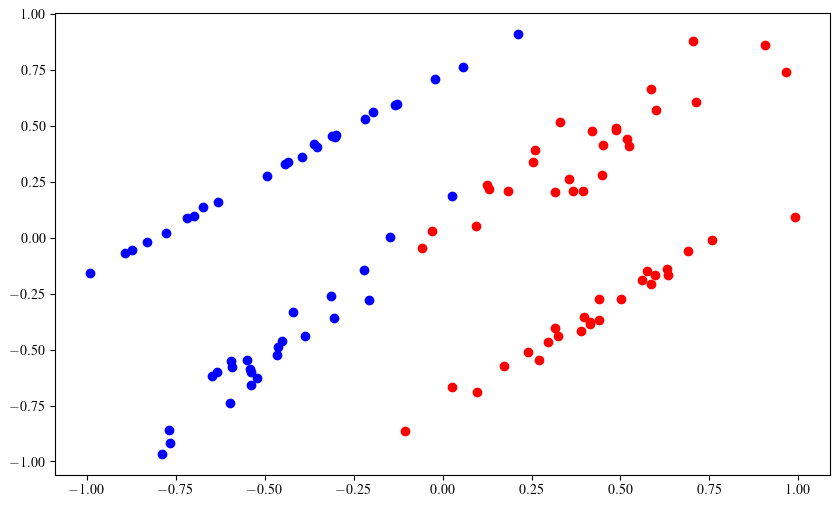

In [68]:
kernel_pptn_classifier = SignModelWrapper(kernel_model_pptn)

y = kernel_pptn_classifier(X_tensor)

# Plot the dataset
plt.figure(figsize=(10, 6))
plt.scatter(X[y == -1][:, 0], X[y == -1][:, 1], color='blue', label='Class 0')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='red', label='Class 1')
plt.savefig('./figures/lines_pptn.pdf', format='pdf', bbox_inches='tight')
plt.show()